# Create intake catalog for ERA5 disk access

- This notebook uses the package ecgtools
- We closely follow the example https://ecgtools.readthedocs.io/en/latest/how-to/use-a-custom-parser.html
- This intake catalog is for disk access (glade) only
- ERA5 is stored in the RDA dataset ds633.0. For more details, see: https://rda.ucar.edu/datasets/ds633-0/
- Another example for an ERA5 catalog can be found here: https://tutorials.dkrz.de/tutorial_intake-1-3-dkrz-catalogs-era5.html

In [84]:
# Display output of plots directly in Notebook
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
# import pathlib
import intake
import numpy as np
#import pandas as pd
import xarray as xr
import intake_esm
import glob
from ecgtools import Builder
from ecgtools.builder import INVALID_ASSET, TRACEBACK
# import s3fs
# import seaborn as sns
import re
import pandas as pd
from pathlib import Path


In [42]:
import dask 
from dask_jobqueue import PBSCluster
from dask.distributed import Client
from dask.distributed import performance_report

In [43]:
rda_scratch = '/gpfs/csfs1/collections/rda/scratch/harshah'
rda_data    = '/gpfs/csfs1/collections/rda/data/'
#era5_path   = rda_data + 'ds633.0/e5.oper.an.sfc/'
era5_path   = rda_data + 'ds633.0/'
zarr_path   = rda_scratch + '/tas_zarr/'
#
rda_url     =  'https://request.rda.ucar.edu/'
#This maps to /glade/campaign/collections/rda/transfer/
rda_zarr    = rda_url + 'harshah/pelican_test/tas_zarr/'

In [44]:
# Create a PBS cluster object
cluster = PBSCluster(
    job_name = 'dask-wk24-hpc',
    cores = 1,
    memory = '4GiB',
    processes = 1,
    local_directory = rda_scratch+'/dask/spill',
    resource_spec = 'select=1:ncpus=1:mem=4GB',
    queue = 'casper',
    walltime = '5:00:00',
    #interface = 'ib0'
    interface = 'ext'
)

## Build a custom parser 

### Understand the directory and file structure

In [45]:
era5_folders = sorted(glob.glob(era5_path+'*'))
era5_folders

['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.pl',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.sfc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.instan',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.meanflux',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.minmax',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.invariant',
 '/gpfs/csfs1/collections/rda/data/ds633.0/index.html']

### Some observations
- We observe that there is only one type of ERA data available, therefore the column name era_id = e5
- dataTpe: Two types of data are available, 'an' : Analaysis, 'fc': forecast
- Let us open each of them to see how the individual files are organized

In [46]:
era5_anfolders = sorted(glob.glob('/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/*'))
era5_anfolders[:5]

['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194002',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194003',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194004',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194005']

In [47]:
era5_fcfiles = sorted(glob.glob('/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/*/*'))
era5_fcfiles[:5]

['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_008_sro.ll025sc.1940010106_1940011606.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_008_sro.ll025sc.1940010106_1940011606.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_008_sro.ll025sc.1940011606_1940020106.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_008_sro.ll025sc.1940011606_1940020106.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_009_ssro.ll025sc.1940010106_1940011606.grb']

In [48]:
era_mflux = sorted(glob.glob(era5_path+ 'e5.oper.fc.sfc.meanflux/*/*'))
era_mflux[:5]

['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.meanflux/194001/e5.oper.fc.sfc.meanflux.235_020_msror.ll025sc.1940010106_1940011606.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.meanflux/194001/e5.oper.fc.sfc.meanflux.235_020_msror.ll025sc.1940010106_1940011606.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.meanflux/194001/e5.oper.fc.sfc.meanflux.235_020_msror.ll025sc.1940011606_1940020106.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.meanflux/194001/e5.oper.fc.sfc.meanflux.235_020_msror.ll025sc.1940011606_1940020106.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.meanflux/194001/e5.oper.fc.sfc.meanflux.235_021_mssror.ll025sc.1940010106_1940011606.grb']

In [68]:
%%time
era5_anfiles = sorted(glob.glob(era5_folders[2]+'/*/*'))
era5_anfiles[:10]

CPU times: user 103 ms, sys: 72.6 ms, total: 175 ms
Wall time: 221 ms


['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_053_vima.ll025sc.1940010100_1940013123.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_053_vima.ll025sc.1940010100_1940013123.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_054_vit.ll025sc.1940010100_1940013123.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_054_vit.ll025sc.1940010100_1940013123.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_059_vike.ll025sc.1940010100_1940013123.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_059_vike.ll025sc.1940010100_1940013123.nc',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_060_vithe.ll025sc.1940010100_1940013123.grb',
 '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinte

In [50]:
ds =  xr.open_dataset(era5_fcfiles[1],engine='netcdf4')
ds

<xarray.Dataset> Size: 1GB
Dimensions:                (forecast_initial_time: 30, forecast_hour: 12,
                            latitude: 721, longitude: 1440)
Coordinates:
  * forecast_hour          (forecast_hour) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 240B 1940-0...
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
Data variables:
    SRO                    (forecast_initial_time, forecast_hour, latitude, longitude) float32 1GB ...
    utc_date               (forecast_initial_time) int32 120B ...
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB1 data to netCDF4.
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r10i5n20 4.12.14-95.51-default #1 SMP Fri Apr...
    CONVERSION_DATE:      Thu Mar 16 17:43:44 MDT 2023
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Thu Mar 16 17:43:52 2023: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

### More observations
- Data is saved in monthly files on a 0.25 degree grid.
- There are both NetCDF and GRIB files for each variable with hourly data from 00:00 to 23:00 for the all the days of the month
- File names have ECMFW table numbers https://rda.ucar.edu/datasets/ds633.0/#
- And parameter codes which have a one-to-one correspondence with a variable. See https://codes.ecmwf.int/grib/param-db/

In [53]:
variable_list = [var for var in ds if 'long_name' in ds[var].attrs]
variable_list

['SRO', 'utc_date']

In [54]:
ds['SRO'].attrs.get('long_name', 'NA')

'Surface runoff'

### Build a custom parser

In [55]:
def parse_era5(file_path):
    # Convert file_path to a Path object for easier handling
    file_path = Path(file_path)
    
    # Check if the file is a NetCDF file
    if file_path.suffix != '.nc':
        return {}  # Return an empty dictionary if the file is not a NetCDF file

    # Enhanced regular expression to accurately parse the date-time segments in the filename
    pattern = re.compile(r'''
        (?P<era_id>e5)\.oper\.
        (?P<datatype>[^.]+)
        (?:\.(?P<level_type>[^.]+))?  # Making level_type optional
        \.(?P<step_type>[^.]+)
        \.(?P<table_code>\d+)
        _(?P<param_code>\d+)
        _(?P<variable_short_name>\w+)
        .*?
        (?P<year>\d{4})
        (?P<month>\d{2})
        .*?                           # Skip any characters until the extension
        \.nc$                         # Ensure the file ends with .nc
        ''', re.VERBOSE | re.DOTALL)

    match = pattern.search(file_path.name)

    if match:
        try:
            with xr.open_dataset(file_path) as ds:
                # Assuming there is typically one main variable of interest
                if ds.data_vars:
                    var_name = list(ds.data_vars)[0]  # Select the first variable if no specific variable is assumed
                    var = ds[var_name]
                    short_name = var_name
                    long_name = var.attrs.get('long_name', 'N/A')
                    units = var.attrs.get('units', 'N/A')
                else:
                    short_name, long_name, units = 'N/A', 'N/A', 'N/A'

                details = {
                    'era_id': match.group('era_id'),
                    'datatype': match.group('datatype'),
                    'level_type': match.group('level_type') if match.group('level_type') else '',
                    'step_type': match.group('step_type'),
                    'table_code': match.group('table_code'),
                    'param_code': match.group('param_code'),
                    'variable': short_name,
                    'long_name': long_name,
                    'units': units,
                    'year': match.group('year'),
                    'month': match.group('month'),
                    'format': 'nc',
                    'frequency': 'hourly',  # Assuming hourly frequency based on context
                    'path': str(file_path)  # Include full file path
                }

            return details
        except Exception as e:
            print(f"Failed to open dataset or extract variables: {e}")
            return {}

    else:
        print("Failed to match the filename pattern.")
        return {}  # Return an empty dictionary if no match is found

In [56]:
era5_fcfiles[1]

'/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_008_sro.ll025sc.1940010106_1940011606.nc'

In [57]:
era5_anfiles[1]

'/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/e5.oper.an.vinteg.162_053_vima.ll025sc.1940010100_1940013123.nc'

In [66]:
file_path = era5_folders[2]
df = parse_era5(file_path + '/**/*/')
df

{}

In [63]:
era5_folders[2]

'/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg'

In [61]:
file_path = era5_fcfiles[1]
df = parse_era5(file_path)
df

{'era_id': 'e5',
 'datatype': 'fc',
 'level_type': 'sfc',
 'step_type': 'accumu',
 'table_code': '128',
 'param_code': '008',
 'variable': 'SRO',
 'long_name': 'Surface runoff',
 'units': 'm',
 'year': '1940',
 'month': '01',
 'format': 'nc',
 'frequency': 'hourly',
 'path': '/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.fc.sfc.accumu/194001/e5.oper.fc.sfc.accumu.128_008_sro.ll025sc.1940010106_1940011606.nc'}

### Pass this parser to a builder object
- We have built a custom parser function which is flexible enough to handle different filepaths.
- Let us now use it to construct a Builder object for a single directory to check if everything works!

In [19]:
print(era5_path+'e5.oper.an.vinteg/194001/')

/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001/


In [20]:
b = Builder(paths=[era5_path+'e5.oper.an.vinteg/194001'],depth=0,exclude_patterns=['*.grb'])
b

Builder(paths=['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001'], storage_options={}, depth=0, exclude_patterns=['*.grb'], include_patterns=[], joblib_parallel_kwargs={})

In [21]:
%%time
b.build(parsing_func= parse_era5)

CPU times: user 378 ms, sys: 111 ms, total: 489 ms
Wall time: 6.39 s


Builder(paths=['/gpfs/csfs1/collections/rda/data/ds633.0/e5.oper.an.vinteg/194001'], storage_options={}, depth=0, exclude_patterns=['*.grb'], include_patterns=[], joblib_parallel_kwargs={})

In [22]:
b.df.head()

,era_id,datatype,level_type,step_type,table_code,param_code,variable,long_name,units,year,month,format,frequency,path
0,e5,an,,vinteg,162,053,VIMA,Vertical integral of mass of atmosphere,kg m**-2,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
1,e5,an,,vinteg,162,054,VIT,Vertical integral of temperature,K kg m**-2,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
2,e5,an,,vinteg,162,059,VIKE,Vertical integral of kinetic energy,J m**-2,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
3,e5,an,,vinteg,162,060,VITHE,Vertical integral of thermal energy,J m**-2,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
4,e5,an,,vinteg,162,061,VIPIE,Vertical integral of potential+internal energy,J m**-2,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...


In [23]:
# %%time
# b.save(
#     name='era5_catalog_test',
#     path_column_name='path',
#     variable_column_name='variable',
#     data_format='netcdf',
#     groupby_attrs=[
#         'datatype',
#         'level_type',
#         'step_type'
#     ],
#     aggregations=[
#         {'type': 'union', 'attribute_name': 'variable'},
#         {
#             'type': 'join_existing',
#             'attribute_name': 'time_range',
#             'options': {'dim': 'time', 'coords': 'minimal', 'compat': 'override'},
#         },
#     ],
#     description = 'This is the NetCDF collection of vertical integrals in the ERA5 dataset ds633, which is a part of NCAR glade collection. ',
#     directory = '/gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs/'
# )

Successfully wrote ESM catalog json file to: file:///gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs//era5_catalog_test.json
CPU times: user 4.08 ms, sys: 757 µs, total: 4.84 ms
Wall time: 47 ms


## Open the saved catalog and test its properties

In [24]:
test_catalog = intake.open_esm_datastore('/gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs/era5_catalog_test.json')
test_catalog

,unique
era_id,1
datatype,1
level_type,0
step_type,1
table_code,1
param_code,36
variable,36
long_name,36
units,7
year,1


In [25]:
test_ds = test_catalog.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'datatype.step_type'


### Inspect the keys

In [26]:
test_ds.keys()

dict_keys(['an.vinteg'])

In [27]:
test_ds['an.vinteg']

<xarray.Dataset> Size: 111GB
Dimensions:    (time: 744, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1940-01-01 ... 1940-01-31T23:00:00
    utc_date   (time) int32 3kB dask.array<chunksize=(744,), meta=np.ndarray>
Data variables: (12/36)
    VIEC       (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIGD       (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIGE       (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIGN       (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIIWD      (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIIWE      (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    ...         ...
    VITOED     (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VITOEE     (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VITOEN     (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIWVD      (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIWVE      (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
    VIWVN      (time, latitude, longitude) float32 3GB dask.array<chunksize=(27, 139, 277), meta=np.ndarray>
Attributes: (12/17)
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.8.1
    CONVERSION_PLATFORM:             Linux r1i2n8 4.12.14-95.51-default #1 SM...
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    ...                              ...
    intake_esm_attrs:year:           1940
    intake_esm_attrs:month:          1
    intake_esm_attrs:format:         nc
    intake_esm_attrs:frequency:      hourly
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          an.vinteg

## Select variable and plot
- I am selecting Vertical Integral of temperature

In [28]:
test_ds['an.vinteg'].VIT

<xarray.DataArray 'VIT' (time: 744, latitude: 721, longitude: 1440)> Size: 3GB
dask.array<open_dataset-VIT, shape=(744, 721, 1440), dtype=float32, chunksize=(27, 139, 277), chunktype=numpy.ndarray>
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1940-01-01 ... 1940-01-31T23:00:00
    utc_date   (time) int32 3kB dask.array<chunksize=(744,), meta=np.ndarray>
Attributes: (12/14)
    long_name:                                          Vertical integral of ...
    short_name:                                         vit
    units:                                              K kg m**-2
    original_format:                                    WMO GRIB 1 with ECMWF...
    ecmwf_local_table:                                  162
    ecmwf_parameter:                                    54
    ...                                                 ...
    grid_specification:                                 0.25 degree x 0.25 de...
    rda_dataset:                                        ds633.0
    rda_dataset_url:                                    https:/rda.ucar.edu/d...
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric vert...
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7

## Spin up cluster

In [151]:
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38319/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38319/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:34391,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38319/status,Total threads: 0
Started: 1 week ago,Total memory: 0 B


In [152]:
cluster.scale(15)
cluster

Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38319/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.98:34391,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/harshah/proxy/38319/status,Total threads: 0
Started: 1 week ago,Total memory: 0 B


### Builder object for all files

In [35]:
#b_an = Builder(paths=[era5_path+'e5.oper.an.*/'],depth=1,exclude_patterns=['*.grb'])
# b_era = Builder(paths=[era5_path],depth=2,exclude_patterns=['*.grb','.html'],joblib_parallel_kwargs = {
#          'n_jobs': 15,  # Utilize all 10 cores
#          'backend': 'loky',  # 'loky' is good for managing processes, especially if you're not using Dask integration
#         })
# b_era

Builder(paths=['/gpfs/csfs1/collections/rda/data/ds633.0/'], storage_options={}, depth=2, exclude_patterns=['*.grb', '.html'], include_patterns=[], joblib_parallel_kwargs={'n_jobs': 15, 'backend': 'loky'})

In [36]:
# %%time
# b_era.build(parsing_func= parse_era5)

CPU times: user 39min 43s, sys: 2min 41s, total: 42min 24s
Wall time: 4h 56min 22s


Builder(paths=['/gpfs/csfs1/collections/rda/data/ds633.0/'], storage_options={}, depth=2, exclude_patterns=['*.grb', '.html'], include_patterns=[], joblib_parallel_kwargs={'n_jobs': 15, 'backend': 'loky'})

In [98]:
b_era_df = b_era.df
b_era_df

,era_id,datatype,level_type,step_type,table_code,param_code,variable,long_name,units,year,month,format,frequency,path
0,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
1,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
2,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
3,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
4,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785081,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785082,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785083,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
785084,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Inspect the catalog
- We observe that there are several rows which are NaN, we should drop them before saving our catalog
- We also see that not all files have a `level_type'. So, we should probably not use this column as a groupby attribute

In [99]:
# Check for NaN values in the 'datatype' column
print(b_era_df['datatype'].isnull().value_counts())

datatype
False    785068
True         18
Name: count, dtype: int64


In [101]:
# Replace NaN values in the 'datatype' column with the string 'NA'
b_era_df = b_era_df.dropna()
b_era_df

,era_id,datatype,level_type,step_type,table_code,param_code,variable,long_name,units,year,month,format,frequency,path
0,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
1,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
2,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
3,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
4,e5,an,,pl,128,060,PV,Potential vorticity,K m**2 kg**-1 s**-1,1940,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
785066,e5,fc,sfc,minmax,128,202,MN2T,Minimum temperature at 2 metres since previous...,K,2024,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
785067,e5,fc,sfc,minmax,228,226,MXTPR,Maximum total precipitation rate since previou...,kg m**-2 s**-1,2024,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
785068,e5,fc,sfc,minmax,228,226,MXTPR,Maximum total precipitation rate since previou...,kg m**-2 s**-1,2024,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...
785069,e5,fc,sfc,minmax,228,227,MNTPR,Minimum total precipitation rate since previou...,kg m**-2 s**-1,2024,01,nc,hourly,/gpfs/csfs1/collections/rda/data/ds633.0/e5.op...


In [124]:
b_era_df['level_type'] = b_era_df['level_type'].replace('', 'NA')
b_era.df = b_era_df  # Update the builder's DataFrame with the modified one
# Check for NaN values in the 'level_type' column
print(b_era_df['level_type'].isnull().value_counts())

level_type
False    785068
Name: count, dtype: int64


In [125]:
b_era_df['level_type']

0          NA
1          NA
2          NA
3          NA
4          NA
         ... 
785066    sfc
785067    sfc
785068    sfc
785069    sfc
785070    sfc
Name: level_type, Length: 785068, dtype: object

- Check to see which files were not parsed by calling .invalid_assets

In [149]:
b_era.invalid_assets

""


In [131]:
%%time
b_era.save(
    name='era5_catalog',
    path_column_name='path',
    variable_column_name='variable',
    data_format='netcdf',
    groupby_attrs=[
        'datatype',
        #'level_type',
        'step_type'
    ],
    aggregations=[
        {'type': 'union', 'attribute_name': 'variable'},
        {
            'type': 'join_existing',
            'attribute_name': 'time_range',
            'options': {'dim': 'time', 'coords': 'minimal', 'compat': 'override'},
        },
    ],
    description = 'This is the NetCDF collection of the publicly accessible ERA5 dataset, which is a part of the NCAR glade collection. ',
    directory = '/gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs'
)

Successfully wrote ESM catalog json file to: file:///gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs/era5_catalog.json
CPU times: user 5.3 s, sys: 59.5 ms, total: 5.36 s
Wall time: 6.59 s


## Test the catalog, load some data and plot

In [138]:
# test = pd.read_json('/gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs/era5_catalog.json')
# test

In [133]:
col = intake.open_esm_datastore('/gpfs/csfs1/collections/rda/scratch/harshah/intake_catalogs/era5_catalog.json')
col

,unique
era_id,1
datatype,2
level_type,1
step_type,7
table_code,4
param_code,164
variable,212
long_name,212
units,33
year,85


In [146]:
cat = col.search(variable='MN2T',frequency='hourly')
cat

,unique
era_id,1
datatype,1
level_type,1
step_type,1
table_code,1
param_code,1
variable,1
long_name,1
units,1
year,85


In [153]:
dsets = cat.to_dataset_dict()


--> The keys in the returned dictionary of datasets are constructed as follows:
	'datatype.step_type'


- Inspect keys

In [155]:
dsets.keys()

dict_keys(['fc.minmax'])

In [157]:
ds = dsets['fc.minmax']
ds

<xarray.Dataset> Size: 3TB
Dimensions:                (forecast_initial_time: 61424, forecast_hour: 12,
                            latitude: 721, longitude: 1440)
Coordinates:
  * forecast_hour          (forecast_hour) int32 48B 1 2 3 4 5 6 7 8 9 10 11 12
  * forecast_initial_time  (forecast_initial_time) datetime64[ns] 491kB 1940-...
  * latitude               (latitude) float64 6kB 90.0 89.75 ... -89.75 -90.0
  * longitude              (longitude) float64 12kB 0.0 0.25 0.5 ... 359.5 359.8
    utc_date               (forecast_initial_time) int32 246kB dask.array<chunksize=(30,), meta=np.ndarray>
Data variables:
    MN2T                   (forecast_initial_time, forecast_hour, latitude, longitude) float32 3TB dask.array<chunksize=(1, 12, 721, 1440), meta=np.ndarray>
Attributes: (12/18)
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    intake_esm_vars:                 ['MN2T']
    intake_esm_attrs:era_id:         e5
    ...                              ...
    intake_esm_attrs:long_name:      Minimum temperature at 2 metres since pr...
    intake_esm_attrs:units:          K
    intake_esm_attrs:format:         nc
    intake_esm_attrs:frequency:      hourly
    intake_esm_attrs:_data_format_:  netcdf
    intake_esm_dataset_key:          fc.minmax

CPU times: user 364 ms, sys: 21.8 ms, total: 386 ms
Wall time: 828 ms


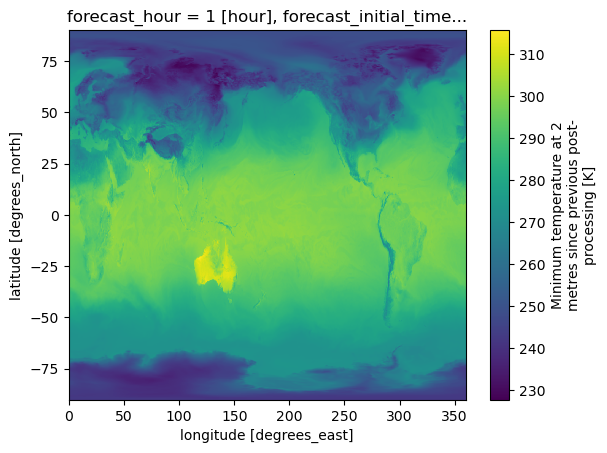

In [158]:
%%time
ds.MN2T.isel(forecast_initial_time=0,forecast_hour=0).plot()